### import 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

ModuleNotFoundError: No module named 'seaborn'

### 1. 데이터 전처리

#### 1-1 걸음수 데이터 전처리 (user_step_2020 데이터)

In [ ]:
# 걸음 수 데이터 (user_step_2020)
# e4acc(가속도계) 데이터를 활용하여 걸음 수를 추정해낸 데이터
# e4acc 데이터는 용량이 커서, 걸음 수를 추정해낸 csv 파일만 제시함
# e4acc 데이터 : https://nanum.etri.re.kr/share/schung1/ETRILifelogDataset2020?lang=ko_KR (user01-06 데이터 참고)
# 관련 논문 : https://www.kci.go.kr/kciportal/ci/sereArticleSearch/ciSereArtiView.kci?sereArticleSearchBean.artiId=ART001274939

In [ ]:
# 걸음 수 데이터 전처리
df = 'user01-06 데이터'

# 3축 가속도계 단위 : m/s² -> g 로 변경 
df[['x','y','z']] = df[['x','y','z']]/9.8

# 잡음 제거를 위한 LPF 알고리즘
import numpy as np
from scipy.signal import butter, filtfilt

x = np.array(df['x'])
y = np.array(df['y'])
z = np.array(df['z'])


def low_pass_filter(data, cutoff=2.5, fs=30, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)


df['x_filtered'] = low_pass_filter(x)
df['y_filtered'] = low_pass_filter(y)
df['z_filtered'] = low_pass_filter(z)

In [ ]:
# 3축 가속도계 데이터를 통한 에너지값 변환
df[['x_filtered', 'y_filtered', 'z_filtered']] = df[['x_filtered', 'y_filtered', 'z_filtered']] ** 2
df['E_filtered'] = np.sqrt(df['x_filtered'] + df['y_filtered'] + df['z_filtered'])

# 0.75미만의 작은 에너지값은 0으로 처리
df[df['E_filtered'] < 0.75] = 0

In [ ]:
# 갱신되는 임계값을 통한 걸음 수 추정 알고리즘
def a_lookup(peak_val):
    if peak_val < 1.1:
        return 5.3
    elif peak_val < 1.4:
        return 5.4
    elif peak_val < 1.6:
        return 4
    else:
        return 3.8


def compute_adaptive_thresholds(peaks, E):
    thresholds = []

    for i in range(1, len(peaks) + 1):
        if i == 1:
            thresholds.append(0.95)

        elif i <= 5:
            prev_peaks = [E[peaks[j]] for j in range(i - 1)]
            basic_values = [0.95] * (5 - (i - 1))
            threshold = np.mean(prev_peaks + basic_values)
            thresholds.append(threshold)
        elif i == 6:
            prev_peaks = [E[peaks[j]] for j in range(5)]
            threshold = np.mean(prev_peaks)
            thresholds.append(threshold)
        else:

            peak1_5 = [E[peaks[i - j -1]] for j in range(2, 7)]
            peak2_6 = [E[peaks[i - j ]] for j in range(2, 7)]
            PD = (np.mean(peak1_5) - np.mean(peak2_6)) / 10
            peak1 = E[peaks[i - 2]]
            a = a_lookup(peak1)
            threshold = PD + (peak1 * a / 5)
            thresholds.append(threshold)

    return thresholds


In [ ]:
from scipy.signal import find_peaks

peaks, _ = find_peaks(df['E_filtered'], height=0.75)  

E = df['E_filtered'].values

adaptive_thresholds = compute_adaptive_thresholds(peaks, E)

valid_peaks = []
last_peak_time = -np.inf

for i, p in enumerate(peaks):
    current_time = df['timestamp'].iloc[p]
    peak_value = E[p]
    threshold = adaptive_thresholds[i]

    if peak_value >= threshold and current_time - last_peak_time >= 0.3:
        valid_peaks.append(p)
        last_peak_time = current_time


#### 1-2 카페인, 알코올 데이터 전처리(user_survey_2020 데이터)

In [71]:
# pm 데이터만 남기기
user_survey_2020_pm = user_survey_2020[user_survey_2020['amPm']=='pm']
user_survey_2020_pm.drop(columns=['startInput','endInput','sleep','sleepProblem','dream','amEmotion','amCondition','pmEmotion','pmStress','pmFatigue','user_number'],inplace=True)

# caffeine 음료 중 caffeinated drink 삭제
user_survey_2020_pm = user_survey_2020_pm[~(user_survey_2020_pm['caffeine']=='caffeinated drink')]

C:\Users\joonhyun\AppData\Local\Temp\ipykernel_8436\4159534210.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_survey_2020_pm.drop(columns=['startInput','endInput','sleep','sleepProblem','dream','amEmotion','amCondition','pmEmotion','pmStress','pmFatigue','user_number'],inplace=True)


In [72]:
user_survey_2020_pm['caffeine'].value_counts()

caffeine
coffee    256
coke        4
tea         4
Name: count, dtype: int64

In [73]:
# 음료의 평균 카페인 함량을 통한 섭취 카페인양 추정 알고리즘
caffeine_per_100ml = {
    'coffee': 43.9,
    'coke': 10.1,
    'tea': 22.5
}


def compute_caffeine(row):
    drink = row['caffeine']
    amount = row['cAmount(ml)']
    if pd.notnull(drink) and pd.notnull(amount):
        if drink in caffeine_per_100ml:
            return (caffeine_per_100ml[drink] / 100) * amount
    return 0

user_survey_2020_pm['caffeine_mg'] = user_survey_2020_pm.apply(compute_caffeine, axis=1)


In [74]:
# alcohol 음료 중 cognac, kaoliang, not specified 삭제
user_survey_2020_pm = user_survey_2020_pm[user_survey_2020_pm['alcohol'].isin(['cognac', 'kaoliang','not specified']) == False]

In [75]:
user_survey_2020_pm['alcohol'].value_counts()

alcohol
beer              45
soju              31
wine               6
soju&beer          5
beer&rice wine     1
rice wine          1
wine&beer          1
Name: count, dtype: int64

In [76]:
# 음료의 평균 알코올 함량을 통한 섭취 알코올양 추정 알고리즘
alcohol_per_100ml = {
    'beer': 3.6,
    'soju': 15.9,
    'wine': 9.6,
    'rice wine': 4.7,
    'soju&beer':9.6,
    'beer&rice wine':4.2,
    'wine&beer':6.6
}


def compute_alcohol(row):
    drink = row['alcohol']
    amount = row['aAmount(ml)']
    if pd.notnull(drink) and pd.notnull(amount):
        if drink in alcohol_per_100ml:
            return (alcohol_per_100ml[drink] / 100) * amount
    return 0

user_survey_2020_pm['alcohol_g'] = user_survey_2020_pm.apply(compute_alcohol, axis=1)


In [77]:
user_survey_2020_pm

,userId,date,amPm,caffeine,cAmount(ml),alcohol,aAmount(ml),caffeine_mg,alcohol_g
1,user01,2020-08-30,pm,NaN,NaN,NaN,NaN,0.00,0.0
3,user01,2020-08-31,pm,coffee,250.0,NaN,NaN,109.75,0.0
5,user01,2020-09-01,pm,coffee,1000.0,NaN,NaN,439.00,0.0
7,user01,2020-09-02,pm,coffee,500.0,NaN,NaN,219.50,0.0
17,user01,2020-09-07,pm,coffee,500.0,NaN,NaN,219.50,0.0
...,...,...,...,...,...,...,...,...,...
1221,user30,2020-09-23,pm,NaN,NaN,NaN,NaN,0.00,0.0
1223,user30,2020-09-24,pm,NaN,NaN,NaN,NaN,0.00,0.0
1225,user30,2020-09-25,pm,NaN,NaN,NaN,NaN,0.00,0.0
1227,user30,2020-09-26,pm,NaN,NaN,NaN,NaN,0.00,0.0


#### 1-3 잔 시간 도출하기 (user_sleep_2020 데이터)

In [79]:
user_sleep_2020 = user_sleep_2020[['userId','data_new','startDt','endDt','sleep_score']]

In [80]:
# sleep_duration의 단위를 시간으로 변경
user_sleep_2020['sleep_duration'] = (user_sleep_2020['endDt'] - user_sleep_2020['startDt'])/3600
user_sleep_2020.drop(columns=['startDt','endDt'],inplace=True)
user_sleep_2020.head()

,userId,data_new,sleep_score,sleep_duration
0,user01,2020-08-30,83,7.983333
1,user01,2020-08-31,82,6.883333
2,user01,2020-09-01,53,6.650000
3,user01,2020-09-02,82,7.566667
4,user01,2020-09-03,60,6.283333


#### 1-4 성별 데이터 전처리(user_info_2020 데이터)

In [82]:
# 데이터 수치화 하기 : 남자(1), 여자(0)
user_info_2020 = user_info_2020[['userId','gender','age']]
user_info_2020['gender'] = user_info_2020['gender'].map({'M': 1, 'F': 0})

### 2. 데이터 병합하기(user_sleep_2020, user_survey_2020, user_step_2020, user_info_2020)

In [83]:
# 데이터 병합 : user_sleep_2020(sleep_score,sleep_duration) & user_survey_2020_pm(caffeine,alcohol) & user_step_2020 & user_info_2020

In [84]:
user_sleep_2020.rename(columns={'data_new':'date'},inplace=True)
user_survey_2020_pm.drop(columns=['amPm','caffeine','cAmount(ml)','alcohol','aAmount(ml)'],inplace=True)


df = pd.merge(user_sleep_2020, user_survey_2020_pm, on = ['userId','date'],how='inner')
df['date'] = pd.to_datetime(df['date'])

user_step_2020.drop(columns='date',inplace=True)
user_step_2020.rename(columns={'date_new':'date','userID':'userId'},inplace=True)
user_step_2020['date'] = pd.to_datetime(user_step_2020['date'])

df = pd.merge(df,user_step_2020,on=['userId','date'],how='inner')
df = pd.merge(df, user_info_2020, on='userId', how='left')

merge_df = df[['userId','gender','age','date','caffeine_mg','alcohol_g','step_count','sleep_duration','sleep_score']]
merge_df.head()

,userId,gender,age,date,caffeine_mg,alcohol_g,step_count,sleep_duration,sleep_score
0,user01,1,27,2020-08-30,0.00,0.0,1859,7.983333,83
1,user01,1,27,2020-08-31,109.75,0.0,4624,6.883333,82
2,user01,1,27,2020-09-07,219.50,0.0,4591,8.900000,83
3,user01,1,27,2020-09-12,0.00,0.0,2244,8.016667,71
4,user01,1,27,2020-09-13,0.00,0.0,3933,8.716667,86


In [85]:
# 중복 날짜 제거
duplicate_df = merge_df[['userId','date']].value_counts(sort=False)
print(duplicate_df[duplicate_df>=2])
merge_df = merge_df.sort_values(by = ['userId','date','sleep_duration'], ascending=[True,True,False]).drop_duplicates(subset=['userId', 'date'], keep='first')

userId  date      
user01  2020-09-25    2
        2020-09-26    2
user02  2020-09-26    2
user04  2020-09-05    2
        2020-09-11    2
        2020-09-18    2
        2020-09-19    2
        2020-09-26    2
user06  2020-10-01    3
user07  2020-09-04    2
        2020-09-16    2
        2020-09-20    2
        2020-09-23    2
user08  2020-09-05    2
        2020-09-21    2
user12  2020-09-06    2
        2020-09-07    2
        2020-09-08    2
        2020-09-09    2
        2020-09-19    2
        2020-09-25    2
        2020-09-26    2
user21  2020-09-16    2
user23  2020-09-02    2
        2020-09-11    2
user24  2020-09-23    2
user26  2020-09-05    2
        2020-09-12    2
        2020-09-14    2
user27  2020-09-04    2
        2020-09-12    2
user30  2020-09-23    2
Name: count, dtype: int64


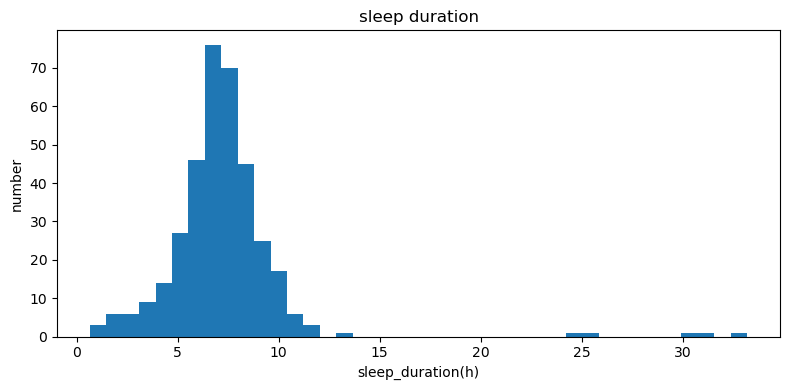

In [86]:
plt.figure(figsize=(8, 4))
plt.hist(merge_df["sleep_duration"], bins=40)
plt.xlabel("sleep_duration(h)")
plt.ylabel("number")
plt.title("sleep duration")
plt.tight_layout()
plt.show()

In [87]:
# iqr 방식을 통해 sleep_duration의 이상치 처리

def prepocessing_iqr(df,column):
  q1 = df[column].quantile(0.25)
  q3 = df[column].quantile(0.75)
  iqr = (q3-q1) *1.5

  df_prepocessing = df[(df[column]<= (q3+iqr)) & (df[column]>= (q1-iqr))]
  return df_prepocessing

prepocessing_df = prepocessing_iqr(merge_df,'sleep_duration')

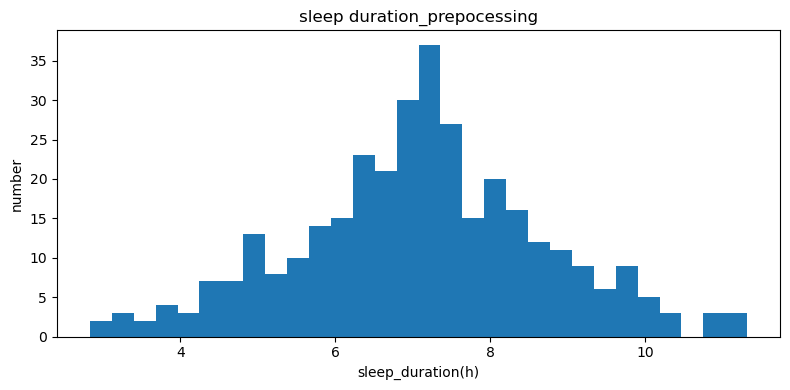

In [88]:
plt.figure(figsize=(8, 4))
plt.hist(prepocessing_df["sleep_duration"], bins=30)
plt.xlabel("sleep_duration(h)")
plt.ylabel("number")
plt.title("sleep duration_prepocessing")
plt.tight_layout()
plt.show()

In [89]:
prepocessing_df = prepocessing_df.reset_index(drop=True)
prepocessing_df

,userId,gender,age,date,caffeine_mg,alcohol_g,step_count,sleep_duration,sleep_score
0,user01,1,27,2020-08-30,0.00,0.0,1859,7.983333,83
1,user01,1,27,2020-08-31,109.75,0.0,4624,6.883333,82
2,user01,1,27,2020-09-07,219.50,0.0,4591,8.900000,83
3,user01,1,27,2020-09-12,0.00,0.0,2244,8.016667,71
4,user01,1,27,2020-09-13,0.00,0.0,3933,8.716667,86
...,...,...,...,...,...,...,...,...,...
333,user30,1,26,2020-09-21,0.00,0.0,2617,7.150000,56
334,user30,1,26,2020-09-22,0.00,0.0,3461,6.900000,74
335,user30,1,26,2020-09-23,0.00,0.0,3598,6.966667,56
336,user30,1,26,2020-09-24,0.00,0.0,2204,6.133333,56


### 3. 모델 구조

In [ ]:
# sleep_duration을 가변변수로 두고 모델을 돌려서 가장 높은 sleep_socre가 나올 때의 sleep_duration을 출력

In [91]:
# 모델 학습
# input : gender, age, caffeine_mg, alcohol_g, step_count, sleep_duration
# output : sleep_score

# 모델 사용
# 입력 : gender, age, caffeine_mg, alcohol_g, step_count
# 가변 변수 : sleep_duration
# 출력 : sleep_duration

In [92]:
# 모델 구조 알고리즘
def recommend_sleep_duration(model, scaler, gender,age,caffeine_mg,alcohol_g,step_count,
                              duration_range=(4.0, 12.0), step=0.1):

    base_features = np.array([gender, age, caffeine_mg, alcohol_g, step_count])
    durations = np.arange(duration_range[0], duration_range[1] + step, step)

    best_score = -np.inf
    best_duration = None

    for duration in durations:
        full_input = np.append(base_features, duration).reshape(1, -1)
        scaled_input = scaler.transform(full_input)

        score = model.predict(scaled_input)[0]

        if score > best_score:
            best_score = score
            best_duration = duration

    return best_duration, best_score

### 4. 다양한 모델 (LinearRegression, RandomForestRegressor, KNeighborsRegressor, GradientBoostingRegressor)

#### 4-1 데이터 증강 전

In [95]:
# input & ouput
features = ['gender', 'age', 'caffeine_mg', 'alcohol_g', 'step_count', 'sleep_duration']
target = 'sleep_score'

X = prepocessing_df[features]
y = prepocessing_df[target]

# 데이터 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# train & test 데이터
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [96]:
# LinearRegression
model_LR = LinearRegression()
model_LR.fit(X_train, y_train)
print(f"train score : {model_LR.score(X_train,y_train):.3f}")
print(f"test score : {model_LR.score(X_test,y_test):.3f}")

train score : 0.505
test score : 0.343


In [97]:
# RandomForestRegressor
model_RFR = RandomForestRegressor(random_state=42)
model_RFR.fit(X_train, y_train)
print(f"train score : {model_RFR.score(X_train,y_train):.3f}")
print(f"test score : {model_RFR.score(X_test,y_test):.3f}")

train score : 0.930
test score : 0.336


In [98]:
# KNeighborsRegressor
model_KR = KNeighborsRegressor()
model_KR.fit(X_train, y_train)
print(f"train score : {model_KR.score(X_train,y_train):.3f}")
print(f"test score : {model_KR.score(X_test,y_test):.3f}")

train score : 0.705
test score : 0.267


In [99]:
# GradientBoostingRegressor 모델
model_GBR = GradientBoostingRegressor(random_state=42)
model_GBR.fit(X_train, y_train)
print(f"train score : {model_GBR.score(X_train,y_train):.3f}")
print(f"test score : {model_GBR.score(X_test,y_test):.3f}")

train score : 0.855
test score : 0.352


#### 4-2 데이터 증강 후

In [100]:
# 데이터 증강 알고리즘 : 가우시안 노이즈 추가

import numpy as np
import pandas as pd

def augment_selected_features(df, noise_level=0.05, n_aug_per_row=4,seed=42):
    np.random.seed(seed)
    augmented_rows = []

    for _, row in df.iterrows():
        for _ in range(n_aug_per_row):
            new_row = row.copy()

            # sleep_duration: Gaussian 노이즈 추가
            new_row['sleep_duration'] += np.random.normal(
                loc=0, 
                scale=noise_level * row['sleep_duration']
            )

            # step_count: Gaussian 노이즈 추가 후 정수로 반올림
            new_row['step_count'] += int(np.random.normal(
                loc=0, 
                scale=noise_level * row['step_count']
            ))

            # step_count & sleep_duration 의 음수 방지
            new_row['step_count'] = max(0, new_row['step_count'])
            new_row['sleep_duration'] = max(0, new_row['sleep_duration'])
            
            # caffeine_mg:Gaussian 노이즈 추가 
            new_row['caffeine_mg'] += np.random.normal(
                loc=0, 
                scale=noise_level * row['caffeine_mg']
            )
            
            # alcohol_g:Gaussian 노이즈 추가 
            new_row['alcohol_g'] += np.random.normal(
                loc=0, 
                scale=noise_level * row['caffeine_mg']
            )
						
			# caffeine_mg & alcohol_g 의 음수 방지
            new_row['caffeine_mg'] = max(0, new_row['caffeine_mg'])
            new_row['alcohol_g'] = max(0, new_row['alcohol_g'])
    
            

            
            
            augmented_rows.append(new_row)

    df_aug = pd.DataFrame(augmented_rows)
    return pd.concat([df, df_aug], ignore_index=True)



In [101]:
# 카페인 & 알코올 섭취 여부에 관계없이 모두 증강

In [102]:
# input&output
features = ['gender', 'age', 'caffeine_mg', 'alcohol_g', 'step_count', 'sleep_duration']
target = 'sleep_score'

# train-test 분리
train_df, test_df = train_test_split(prepocessing_df, test_size=0.2, random_state=42)

# train 데이터만 증강
aug_train_df = augment_selected_features(train_df)

X_train = aug_train_df[features]
y_train = aug_train_df[target]

X_test = test_df[features]
y_test = test_df[target]

X_train_scaled = scaler.fit_transform(X_train)   
X_test_scaled = scaler.transform(X_test) 

In [103]:
# 증강한 train 데이터의 분포 확인(caffeine & alcohol)

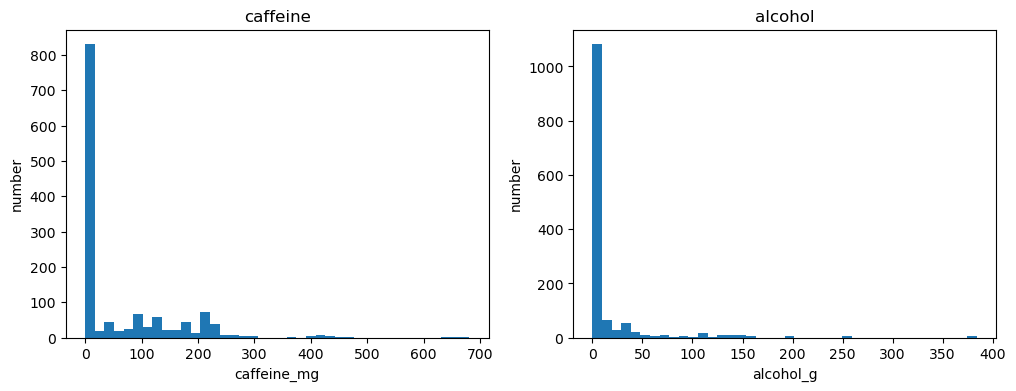

In [104]:
fig, axes = plt.subplots(1,2,figsize=(12,4))

axes[0].hist(aug_train_df['caffeine_mg'], bins=40)
axes[0].set_xlabel("caffeine_mg")
axes[0].set_ylabel("number")
axes[0].set_title("caffeine")

axes[1].hist(aug_train_df['alcohol_g'], bins=40)
axes[1].set_xlabel("alcohol_g")
axes[1].set_ylabel("number")
axes[1].set_title("alcohol")

plt.show()


In [105]:
# LinearRegression
model_LR = LinearRegression()
model_LR.fit(X_train_scaled, y_train)
print(f"train score : {model_LR.score(X_train_scaled,y_train):.3f}")
print(f"test score : {model_LR.score(X_test_scaled,y_test):.3f}")

train score : 0.495
test score : 0.343


In [106]:
# RandomForestRegressor
model_RFR = RandomForestRegressor(random_state=42)
model_RFR.fit(X_train_scaled, y_train)
print(f"train score : {model_RFR.score(X_train_scaled,y_train):.3f}")
print(f"test score : {model_RFR.score(X_test_scaled,y_test):.3f}")

train score : 0.976
test score : 0.382


In [107]:
# KNeighborsRegressor
model_KR = KNeighborsRegressor()
model_KR.fit(X_train_scaled, y_train)
print(f"train score : {model_KR.score(X_train_scaled,y_train):.3f}")
print(f"test score : {model_KR.score(X_test_scaled,y_test):.3f}")

train score : 0.936
test score : 0.163


In [108]:
# GradientBoostingRegressor 모델
model_GBR = GradientBoostingRegressor(random_state=42)
model_GBR.fit(X_train_scaled, y_train)
print(f"train score : {model_GBR.score(X_train_scaled,y_train):.3f}")
print(f"test score : {model_GBR.score(X_test_scaled,y_test):.3f}")

train score : 0.775
test score : 0.444


In [109]:
# 증강에 대한 최적의 파라미터 조합 찾기
def augment_selected_features(df, noise_level=0.05, n_aug_per_row=4,seed=42):
    augmented_rows = []
    np.random.seed(seed)

    for _, row in df.iterrows():
        for _ in range(n_aug_per_row):
            new_row = row.copy()

            new_row['sleep_duration'] += np.random.normal(0, noise_level * row['sleep_duration'])
            new_row['step_count'] += int(np.random.normal(0, noise_level * row['step_count']))
            new_row['step_count'] = max(0, new_row['step_count'])
            new_row['sleep_duration'] = max(0, new_row['sleep_duration'])

            new_row['caffeine_mg'] += np.random.normal(0, noise_level * row['caffeine_mg'])
            new_row['alcohol_g'] += np.random.normal(0, noise_level * row['caffeine_mg'])
            new_row['caffeine_mg'] = max(0, new_row['caffeine_mg'])
            new_row['alcohol_g'] = max(0, new_row['alcohol_g'])

            augmented_rows.append(new_row)

    df_aug = pd.DataFrame(augmented_rows)
    return pd.concat([df, df_aug], ignore_index=True)


# 하이퍼파라미터 조합
noise_levels = [0.01, 0.03, 0.05, 0.1, 0.2]
n_aug_values = [2, 3, 4, 5, 6]

# 특성 및 타겟
features = ['gender', 'age', 'caffeine_mg', 'alcohol_g', 'step_count', 'sleep_duration']
target = 'sleep_score'

# train-test 분리
train_df, test_df = train_test_split(prepocessing_df, test_size=0.2, random_state=42)
X_test = test_df[features]
y_test = test_df[target]

# 결과 저장용 리스트
results = []

for noise in noise_levels:
    for n_aug in n_aug_values:
        aug_train_df = augment_selected_features(train_df, noise_level=noise, n_aug_per_row=n_aug)
        X_train = aug_train_df[features]
        y_train = aug_train_df[target]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # 모델별 학습 및 평가
        models = {
            'LinearRegression': LinearRegression(),
            'RandomForest': RandomForestRegressor(random_state=42),
            'KNeighbors': KNeighborsRegressor(),
            'Gradient':GradientBoostingRegressor(random_state=42)
        }

        for model_name, model in models.items():
            model.fit(X_train_scaled, y_train)
            train_score = model.score(X_train_scaled, y_train)
            test_score = model.score(X_test_scaled, y_test)

            results.append({
                'noise_level': noise,
                'n_aug_per_row': n_aug,
                'model': model_name,
                'train_score': round(train_score, 3),
                'test_score': round(test_score, 3)
            })

# 결과 DataFrame 출력
results_df = pd.DataFrame(results)



In [110]:
results_df[results_df['model']=='LinearRegression']

,noise_level,n_aug_per_row,model,train_score,test_score
0,0.01,2,LinearRegression,0.505,0.343
4,0.01,3,LinearRegression,0.502,0.343
8,0.01,4,LinearRegression,0.505,0.343
12,0.01,5,LinearRegression,0.504,0.343
16,0.01,6,LinearRegression,0.503,0.343
20,0.03,2,LinearRegression,0.504,0.342
24,0.03,3,LinearRegression,0.494,0.343
28,0.03,4,LinearRegression,0.503,0.343
32,0.03,5,LinearRegression,0.498,0.343
36,0.03,6,LinearRegression,0.496,0.344


In [111]:
results_df[results_df['model']=='KNeighbors']

,noise_level,n_aug_per_row,model,train_score,test_score
2,0.01,2,KNeighbors,0.863,0.314
6,0.01,3,KNeighbors,0.958,0.260
10,0.01,4,KNeighbors,0.983,0.029
14,0.01,5,KNeighbors,0.988,-0.004
18,0.01,6,KNeighbors,0.985,0.040
22,0.03,2,KNeighbors,0.862,0.275
26,0.03,3,KNeighbors,0.936,0.261
30,0.03,4,KNeighbors,0.966,0.102
34,0.03,5,KNeighbors,0.960,0.045
38,0.03,6,KNeighbors,0.960,0.030


In [112]:
results_df[results_df['model']=='RandomForest']

,noise_level,n_aug_per_row,model,train_score,test_score
1,0.01,2,RandomForest,0.987,0.305
5,0.01,3,RandomForest,0.991,0.276
9,0.01,4,RandomForest,0.993,0.282
13,0.01,5,RandomForest,0.993,0.231
17,0.01,6,RandomForest,0.993,0.260
21,0.03,2,RandomForest,0.978,0.310
25,0.03,3,RandomForest,0.980,0.302
29,0.03,4,RandomForest,0.984,0.347
33,0.03,5,RandomForest,0.986,0.257
37,0.03,6,RandomForest,0.984,0.308


In [47]:
results_df[results_df['model']=='Gradient']

,noise_level,n_aug_per_row,model,train_score,test_score
3,0.01,2,Gradient,0.837,0.373
7,0.01,3,Gradient,0.839,0.385
11,0.01,4,Gradient,0.827,0.404
15,0.01,5,Gradient,0.830,0.390
19,0.01,6,Gradient,0.828,0.402
23,0.03,2,Gradient,0.815,0.402
27,0.03,3,Gradient,0.801,0.432
31,0.03,4,Gradient,0.801,0.445
35,0.03,5,Gradient,0.797,0.436
39,0.03,6,Gradient,0.795,0.438


In [ ]:
# 카페인 혹은 알코올을 섭취한 데이터에 대해서만 증강

In [48]:
import numpy as np
import pandas as pd

def augment_selected_features(df, noise_level=0.05, n_aug_per_row=4,seed=42):
    np.random.seed(seed)
    augmented_rows = []

    # 카페인 혹은 알코올을 섭취한 경우에 대해서만 증강

    df_filtered = df[(df['caffeine_mg'] > 0) | (df['alcohol_g'] > 0)]

    for _, row in df_filtered.iterrows():
        for _ in range(n_aug_per_row):
            new_row = row.copy()

            # sleep_duration: Gaussian 노이즈 추가
            new_row['sleep_duration'] += np.random.normal(
                loc=0, 
                scale=noise_level * row['sleep_duration']
            )

            # step_count: Gaussian 노이즈 추가 후 정수로 반올림
            new_row['step_count'] += int(np.random.normal(
                loc=0, 
                scale=noise_level * row['step_count']
            ))

            # step_count & sleep_duration 의 음수 방지
            new_row['step_count'] = max(0, new_row['step_count'])
            new_row['sleep_duration'] = max(0, new_row['sleep_duration'])
            
            # caffeine_mg:Gaussian 노이즈 추가 
            new_row['caffeine_mg'] += np.random.normal(
                loc=0, 
                scale=noise_level * row['caffeine_mg']
            )
            
            # alcohol_g:Gaussian 노이즈 추가 
            new_row['alcohol_g'] += np.random.normal(
                loc=0, 
                scale=noise_level * row['caffeine_mg']
            )
						
			# caffeine_mg & alcohol_g 의 음수 방지
            new_row['caffeine_mg'] = max(0, new_row['caffeine_mg'])
            new_row['alcohol_g'] = max(0, new_row['alcohol_g'])
    
            
            augmented_rows.append(new_row)

    df_aug = pd.DataFrame(augmented_rows)
    return pd.concat([df, df_aug], ignore_index=True)



In [49]:
# input&output
features = ['gender', 'age', 'caffeine_mg', 'alcohol_g', 'step_count', 'sleep_duration']
target = 'sleep_score'

# train-test 분리
train_df, test_df = train_test_split(prepocessing_df, test_size=0.2, random_state=42)

# train 데이터만 증강
aug_train_df = augment_selected_features(train_df)

X_train = aug_train_df[features]
y_train = aug_train_df[target]

X_test = test_df[features]
y_test = test_df[target]

X_train_scaled = scaler.fit_transform(X_train)   
X_test_scaled = scaler.transform(X_test) 

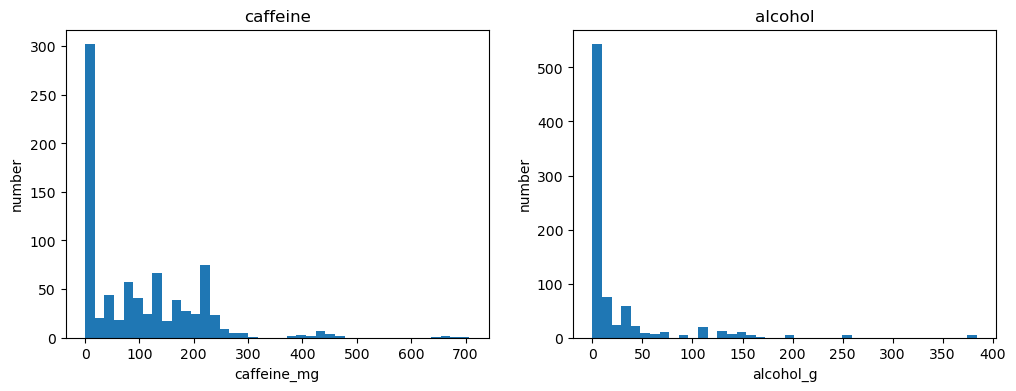

In [50]:
fig, axes = plt.subplots(1,2,figsize=(12,4))

axes[0].hist(aug_train_df['caffeine_mg'], bins=40)
axes[0].set_xlabel("caffeine_mg")
axes[0].set_ylabel("number")
axes[0].set_title("caffeine")

axes[1].hist(aug_train_df['alcohol_g'], bins=40)
axes[1].set_xlabel("alcohol_g")
axes[1].set_ylabel("number")
axes[1].set_title("alcohol")

plt.show()

In [51]:
# 증강에 대한 최적의 파라미터 조합 찾기
def augment_selected_features(df, noise_level=0.05, n_aug_per_row=4,seed=42):
    np.random.seed(seed)
    augmented_rows = []

    df_filtered = df[(df['caffeine_mg'] > 0) | (df['alcohol_g'] > 0)]

    for _, row in df_filtered.iterrows():
        for _ in range(n_aug_per_row):
            new_row = row.copy()

            new_row['sleep_duration'] += np.random.normal(0, noise_level * row['sleep_duration'])
            new_row['step_count'] += int(np.random.normal(0, noise_level * row['step_count']))
            new_row['step_count'] = max(0, new_row['step_count'])
            new_row['sleep_duration'] = max(0, new_row['sleep_duration'])

            new_row['caffeine_mg'] += np.random.normal(0, noise_level * row['caffeine_mg'])
            new_row['alcohol_g'] += np.random.normal(0, noise_level * row['caffeine_mg'])
            new_row['caffeine_mg'] = max(0, new_row['caffeine_mg'])
            new_row['alcohol_g'] = max(0, new_row['alcohol_g'])

            augmented_rows.append(new_row)

    df_aug = pd.DataFrame(augmented_rows)
    return pd.concat([df, df_aug], ignore_index=True)


# 하이퍼파라미터 조합
noise_levels = [0.01, 0.03, 0.05, 0.1, 0.2]
n_aug_values = [2, 3, 4, 5, 6]

# 특성 및 타겟
features = ['gender', 'age', 'caffeine_mg', 'alcohol_g', 'step_count', 'sleep_duration']
target = 'sleep_score'

# train-test 분리
train_df, test_df = train_test_split(prepocessing_df, test_size=0.2, random_state=42)
X_test = test_df[features]
y_test = test_df[target]

# 결과 저장용 리스트
results = []

for noise in noise_levels:
    for n_aug in n_aug_values:
        aug_train_df = augment_selected_features(train_df, noise_level=noise, n_aug_per_row=n_aug)
        X_train = aug_train_df[features]
        y_train = aug_train_df[target]

        X_train_scaled = scaler.fit_transform(X_train)   
        X_test_scaled = scaler.transform(X_test) 

        # 모델별 학습 및 평가
        models = { 
            'LinearRegression': LinearRegression(),
            'RandomForest': RandomForestRegressor(random_state=42),
            'KNeighbors': KNeighborsRegressor(),
            'Gradient':GradientBoostingRegressor(random_state=42)
        }

        for model_name, model in models.items():
            model.fit(X_train_scaled, y_train)
            train_score = model.score(X_train_scaled, y_train)
            test_score = model.score(X_test_scaled, y_test)

            results.append({
                'noise_level': noise,
                'n_aug_per_row': n_aug,
                'model': model_name,
                'train_score': round(train_score, 3),
                'test_score': round(test_score, 3)
            })

# 결과 DataFrame 출력
results_df = pd.DataFrame(results)



In [113]:
results_df[results_df['model']=='LinearRegression']

,noise_level,n_aug_per_row,model,train_score,test_score
0,0.01,2,LinearRegression,0.505,0.343
4,0.01,3,LinearRegression,0.502,0.343
8,0.01,4,LinearRegression,0.505,0.343
12,0.01,5,LinearRegression,0.504,0.343
16,0.01,6,LinearRegression,0.503,0.343
20,0.03,2,LinearRegression,0.504,0.342
24,0.03,3,LinearRegression,0.494,0.343
28,0.03,4,LinearRegression,0.503,0.343
32,0.03,5,LinearRegression,0.498,0.343
36,0.03,6,LinearRegression,0.496,0.344


In [114]:
results_df[results_df['model']=='RandomForest']

,noise_level,n_aug_per_row,model,train_score,test_score
1,0.01,2,RandomForest,0.987,0.305
5,0.01,3,RandomForest,0.991,0.276
9,0.01,4,RandomForest,0.993,0.282
13,0.01,5,RandomForest,0.993,0.231
17,0.01,6,RandomForest,0.993,0.260
21,0.03,2,RandomForest,0.978,0.310
25,0.03,3,RandomForest,0.980,0.302
29,0.03,4,RandomForest,0.984,0.347
33,0.03,5,RandomForest,0.986,0.257
37,0.03,6,RandomForest,0.984,0.308


In [115]:
results_df[results_df['model']=='KNeighbors']

,noise_level,n_aug_per_row,model,train_score,test_score
2,0.01,2,KNeighbors,0.863,0.314
6,0.01,3,KNeighbors,0.958,0.260
10,0.01,4,KNeighbors,0.983,0.029
14,0.01,5,KNeighbors,0.988,-0.004
18,0.01,6,KNeighbors,0.985,0.040
22,0.03,2,KNeighbors,0.862,0.275
26,0.03,3,KNeighbors,0.936,0.261
30,0.03,4,KNeighbors,0.966,0.102
34,0.03,5,KNeighbors,0.960,0.045
38,0.03,6,KNeighbors,0.960,0.030


In [54]:
results_df[results_df['model']=='Gradient']

,noise_level,n_aug_per_row,model,train_score,test_score
3,0.01,2,Gradient,0.865,0.374
7,0.01,3,Gradient,0.865,0.362
11,0.01,4,Gradient,0.874,0.350
15,0.01,5,Gradient,0.871,0.348
19,0.01,6,Gradient,0.870,0.404
23,0.03,2,Gradient,0.850,0.390
27,0.03,3,Gradient,0.845,0.391
31,0.03,4,Gradient,0.849,0.406
35,0.03,5,Gradient,0.837,0.394
39,0.03,6,Gradient,0.837,0.405


In [55]:
import numpy as np
import pandas as pd

def augment_selected_features(df, noise_level=0.05, n_aug_per_row=6,seed=42):
    np.random.seed(seed)
    augmented_rows = []

    # 카페인 혹은 알코올을 섭취한 경우에 대해서만 증강

    df_filtered = df[(df['caffeine_mg'] > 0) | (df['alcohol_g'] > 0)]

    for _, row in df_filtered.iterrows():
        for _ in range(n_aug_per_row):
            new_row = row.copy()

            # sleep_duration: Gaussian 노이즈 추가
            new_row['sleep_duration'] += np.random.normal(
                loc=0, 
                scale=noise_level * row['sleep_duration']
            )

            # step_count: Gaussian 노이즈 추가 후 정수로 반올림
            new_row['step_count'] += int(np.random.normal(
                loc=0, 
                scale=noise_level * row['step_count']
            ))

            # step_count & sleep_duration 의 음수 방지
            new_row['step_count'] = max(0, new_row['step_count'])
            new_row['sleep_duration'] = max(0, new_row['sleep_duration'])
            
            # caffeine_mg:Gaussian 노이즈 추가 
            new_row['caffeine_mg'] += np.random.normal(
                loc=0, 
                scale=noise_level * row['caffeine_mg']
            )
            
            # alcohol_g:Gaussian 노이즈 추가 
            new_row['alcohol_g'] += np.random.normal(
                loc=0, 
                scale=noise_level * row['caffeine_mg']
            )
						
			# caffeine_mg & alcohol_g 의 음수 방지
            new_row['caffeine_mg'] = max(0, new_row['caffeine_mg'])
            new_row['alcohol_g'] = max(0, new_row['alcohol_g'])
    
            
            augmented_rows.append(new_row)

    df_aug = pd.DataFrame(augmented_rows)
    return pd.concat([df, df_aug], ignore_index=True)



In [56]:
# input&output
features = ['gender', 'age', 'caffeine_mg', 'alcohol_g', 'step_count', 'sleep_duration']
target = 'sleep_score'

# train-test 분리
train_df, test_df = train_test_split(prepocessing_df, test_size=0.2, random_state=42)

# train 데이터만 증강
aug_train_df = augment_selected_features(train_df)

X_train = aug_train_df[features]
y_train = aug_train_df[target]

X_test = test_df[features]
y_test = test_df[target]

X_train_scaled = scaler.fit_transform(X_train)   
X_test_scaled = scaler.transform(X_test) 

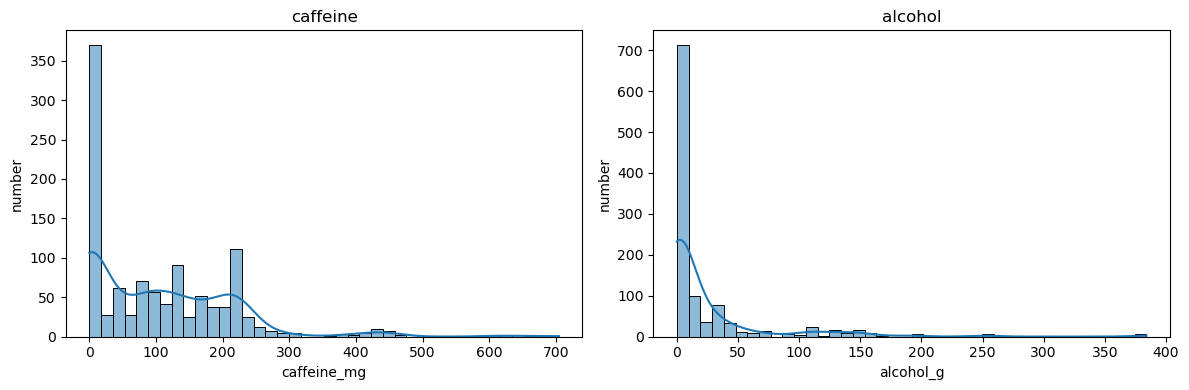

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# caffeine
sns.histplot(aug_train_df['caffeine_mg'], bins=40, kde=True, ax=axes[0])
axes[0].set_xlabel("caffeine_mg")
axes[0].set_ylabel("number")
axes[0].set_title("caffeine")

# alcohol
sns.histplot(aug_train_df['alcohol_g'], bins=40, kde=True, ax=axes[1])
axes[1].set_xlabel("alcohol_g")
axes[1].set_ylabel("number")
axes[1].set_title("alcohol")

plt.tight_layout()
plt.show()

In [57]:
# GradientBoostingRegressor 모델
model_GBR = GradientBoostingRegressor(random_state=42,max_depth=3,n_estimators=100)
model_GBR.fit(X_train_scaled, y_train)
print(f"train score : {model_GBR.score(X_train_scaled,y_train):.3f}")
print(f"test score : {model_GBR.score(X_test_scaled,y_test):.3f}")

train score : 0.828
test score : 0.445
